In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%matplotlib inline
import sys, os, time
sys.path.append("..")
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import fiona
import fiona.transform
import shapely
import shapely.geometry

from scipy.stats import spearmanr

from cafo.utils import filter_polygon

In [2]:
cb_county_fips = []
cb_county_shapes = []
with fiona.open("../data/chesapeake-bay-counties_epsg4326.geojson") as f:
    print(f.crs)
    for row in f:
        cb_county_fips.append(row["properties"]["GEOID"])
        cb_county_shapes.append(shapely.geometry.shape(row["geometry"]))

{'init': 'epsg:4326'}


In [3]:
prediction_shapes = []
prediction_shape_areas = []
num_rejected_shapes = 0
with fiona.open("../output/inference/cb_predictions_3_18_2021.gpkg") as f:
    print(f.crs)
    for row in f:
        if filter_polygon(**row["properties"]):
            prediction_shapes.append(shapely.geometry.shape(row["geometry"]))
            prediction_shape_areas.append(row["properties"]["rectangle_area"])
        else:
            num_rejected_shapes += 1

{'init': 'epsg:4326'}


In [4]:
len(prediction_shapes)

26311

In [5]:
%%time

prediction_county_idxs = []
for prediction_idx, prediction in enumerate(prediction_shapes):
    county_idx = None
    for i, county in enumerate(cb_county_shapes):
        if county.contains(prediction) or county.intersects(prediction):
            county_idx = i
            break
    prediction_county_idxs.append(county_idx)

CPU times: user 1min 43s, sys: 429 ms, total: 1min 43s
Wall time: 1min 43s


In [6]:
summed_area_by_county = defaultdict(int)
counts_by_county = defaultdict(int)
for i in range(len(prediction_county_idxs)):
    
    county_idx = prediction_county_idxs[i]
    if county_idx is not None:    
        county_geoid = cb_county_fips[county_idx]
        area = prediction_shape_areas[i]

        summed_area_by_county[county_geoid] += area
        counts_by_county[county_geoid] += 1

In [7]:
df = pd.read_csv(
    "../data/agcensus_data/poultry_totals_by_county.csv",
    dtype={
        "State ANSI": str,
        "County ANSI": str
    }
)
df["GEOID"] = df["State ANSI"] + df["County ANSI"]
df.set_index("GEOID", inplace=True)

In [8]:
predicted_areas = []
predicted_counts = []
gt_counts = []

for geoid in cb_county_fips:
    predicted_area = summed_area_by_county[geoid]
    predicted_count = counts_by_county[geoid]
    
    if geoid in df.index:
        gt_count = int(df["Value"][geoid].replace(",",""))
    else:
        gt_count = 0
    
    predicted_areas.append(predicted_area)
    predicted_counts.append(predicted_count)
    gt_counts.append(gt_count)
    
predicted_areas = np.array(predicted_areas)
predicted_counts = np.array(predicted_counts)
gt_counts = np.array(gt_counts)

In [9]:
spearmanr(predicted_areas, gt_counts)

SpearmanrResult(correlation=0.6273891646985044, pvalue=7.865482796695445e-24)

In [10]:
spearmanr(predicted_counts, gt_counts)

SpearmanrResult(correlation=0.6265809432064507, pvalue=9.330082081816796e-24)

## Get finer scale

In [11]:
df = pd.read_csv(
    "../data/agcensus_data/agcensus_2017_chickens.csv",
    dtype={
        "State ANSI": str,
        "County ANSI": str
    }
)
df["GEOID"] = df["State ANSI"] + df["County ANSI"]
df.set_index("GEOID", inplace=True)

In [12]:
options = [
    'INVENTORY: (1 TO 49 HEAD)',
    'INVENTORY: (50 TO 99 HEAD)',
    'INVENTORY: (100 TO 399 HEAD)',
    'INVENTORY: (400 TO 3,199 HEAD)',
    'INVENTORY: (3,200 TO 9,999 HEAD)',
    'INVENTORY: (10,000 TO 19,999 HEAD)',
    'INVENTORY: (20,000 TO 49,999 HEAD)',
    'INVENTORY: (50,000 TO 99,999 HEAD)',
    'INVENTORY: (100,000 OR MORE HEAD)',
]

In [13]:
data_item_key = "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY"
for option in options:
    
    mask = (df["Data Item"] == data_item_key) & (df["Domain Category"] == option)
    sub_df = df[mask]
    
    predicted_areas = []
    predicted_counts = []
    gt_counts = []

    for geoid in sub_df.index:
    
        if geoid in cb_county_fips:

            predicted_area = summed_area_by_county[geoid]
            predicted_count = counts_by_county[geoid]
            gt_count = int(sub_df["Value"][geoid].replace(",",""))
        
            predicted_areas.append(predicted_area)
            predicted_counts.append(predicted_count)
            gt_counts.append(gt_count)

    predicted_areas = np.array(predicted_areas)
    predicted_counts = np.array(predicted_counts)
    gt_counts = np.array(gt_counts)
    
    rho, p = spearmanr(predicted_areas, gt_counts)    
    print("%s;%0.2f (%0.4f);%d" % (option, rho, p, len(predicted_areas)))

INVENTORY: (1 TO 49 HEAD);0.19 (0.0116);175
INVENTORY: (50 TO 99 HEAD);0.01 (0.9287);154
INVENTORY: (100 TO 399 HEAD);0.15 (0.0680);140
INVENTORY: (400 TO 3,199 HEAD);0.04 (0.7366);72
INVENTORY: (3,200 TO 9,999 HEAD);0.18 (0.3376);31
INVENTORY: (10,000 TO 19,999 HEAD);0.61 (0.0001);33
INVENTORY: (20,000 TO 49,999 HEAD);0.59 (0.0001);38
INVENTORY: (50,000 TO 99,999 HEAD);0.73 (0.0010);17
INVENTORY: (100,000 OR MORE HEAD);0.42 (0.1189);15


In [14]:
data_item_key = "CHICKENS, LAYERS - OPERATIONS WITH INVENTORY"

xs = []
ys = []

for starting_index in range(9):
    print("Using anything >= %s" % (options[starting_index]))
    
    predicted_areas = {}
    predicted_counts = {}
    gt_counts = {}

    for option in options[starting_index:]:
        mask = (df["Data Item"] == data_item_key) & (df["Domain Category"] == option)
        sub_df = df[mask]

        for geoid in cb_county_fips:

            predicted_area = 0
            predicted_count = 0
            if geoid in summed_area_by_county:
                predicted_area = summed_area_by_county[geoid]
                predicted_count = counts_by_county[geoid]

            gt_count = 0
            if geoid in sub_df.index:
                gt_count = int(sub_df["Value"][geoid].replace(",",""))

            if geoid not in predicted_areas:
                predicted_areas[geoid] = predicted_area
            if geoid not in predicted_counts:
                predicted_counts[geoid] = predicted_count

            if geoid not in gt_counts:
                gt_counts[geoid] = gt_count
            else:
                gt_counts[geoid] += gt_count

    predicted_areas_flat = []
    predicted_counts_flat = []
    gt_counts_flat = []
    for k in gt_counts.keys():
        predicted_areas_flat.append(predicted_areas[k])
        predicted_counts_flat.append(predicted_counts[k])
        gt_counts_flat.append(gt_counts[k])


    predicted_areas_flat = np.array(predicted_areas_flat)
    predicted_counts_flat = np.array(predicted_counts_flat)
    gt_counts_flat = np.array(gt_counts_flat)

    rho, p = spearmanr(predicted_areas_flat, gt_counts_flat)
    print("Area %0.2f (%0.4f)  n=%d" % (rho, p, len(gt_counts_flat)))
    
    xs.append(options[starting_index])
    ys.append(rho)

    rho, p = spearmanr(predicted_counts_flat, gt_counts_flat)
    print("Counts %0.2f (%0.4f)  n=%d" % (rho, p, len(gt_counts_flat)))

Using anything >= INVENTORY: (1 TO 49 HEAD)
Area 0.50 (0.0000)  n=205
Counts 0.50 (0.0000)  n=205
Using anything >= INVENTORY: (50 TO 99 HEAD)
Area 0.52 (0.0000)  n=205
Counts 0.53 (0.0000)  n=205
Using anything >= INVENTORY: (100 TO 399 HEAD)
Area 0.57 (0.0000)  n=205
Counts 0.57 (0.0000)  n=205
Using anything >= INVENTORY: (400 TO 3,199 HEAD)
Area 0.55 (0.0000)  n=205
Counts 0.54 (0.0000)  n=205
Using anything >= INVENTORY: (3,200 TO 9,999 HEAD)
Area 0.55 (0.0000)  n=205
Counts 0.52 (0.0000)  n=205
Using anything >= INVENTORY: (10,000 TO 19,999 HEAD)
Area 0.59 (0.0000)  n=205
Counts 0.56 (0.0000)  n=205
Using anything >= INVENTORY: (20,000 TO 49,999 HEAD)
Area 0.57 (0.0000)  n=205
Counts 0.55 (0.0000)  n=205
Using anything >= INVENTORY: (50,000 TO 99,999 HEAD)
Area 0.38 (0.0000)  n=205
Counts 0.36 (0.0000)  n=205
Using anything >= INVENTORY: (100,000 OR MORE HEAD)
Area 0.28 (0.0001)  n=205
Counts 0.27 (0.0001)  n=205


In [15]:
xs = [
    "$\geq$ 1",
    "$\geq$ 50",
    "$\geq$ 100",
    "$\geq$ 400",
    "$\geq$ 3,200",
    "$\geq$ 10,000",
    "$\geq$ 20,000",
    "$\geq$ 50,000",
    "$\geq$ 100,000"
]

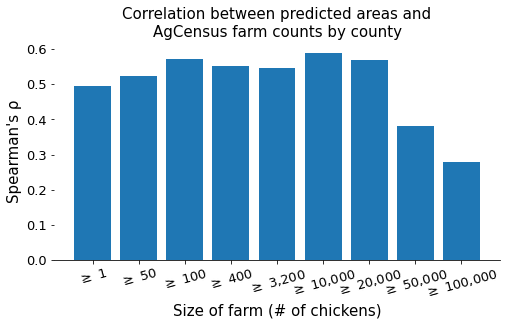

In [16]:
plt.figure(figsize=(8,4))
ax = plt.gca()
plt.bar(xs, ys)
plt.xticks(rotation=15, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Spearman's ρ", fontsize=15)
plt.xlabel("Size of farm (# of chickens)", fontsize=15)
plt.title("Correlation between predicted areas and\nAgCensus farm counts by county", fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()
plt.close()